In [1]:
# Run this code if you get errors with missing requirements
import sys
!{sys.executable} -m pip install mysql-connector

import pandas as pd
import mysql.connector

mydb = mysql.connector.connect(
  host="iiwari-mariadb-server",
  user="root",
  passwd="d41k4Duu",
  database="iiwari_org"
)


In [2]:
# Check database contents
mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT node_id, timestamp, x,y,z,q FROM SensorData WHERE node_id = 54016 AND timestamp > '2019-03-20 09:00:00.000000+00:00' AND timestamp < '2019-03-21 22:05:08.078133+00:00' LIMIT 20000 " );
df = pd.DataFrame(mycursor.fetchall())

print(df)

      node_id                            timestamp   x     y  z    q
0       54016  b'2019-03-21 07:54:39.687645+00:00' -50    50  0  233
1       54016  b'2019-03-21 07:54:40.686633+00:00' -50    50  0   76
2       54016  b'2019-03-21 07:54:41.687915+00:00' -50    50  0   99
3       54016  b'2019-03-21 07:54:43.687457+00:00' -50    50  0   96
4       54016  b'2019-03-21 07:54:44.687414+00:00' -50    50  0   32
...       ...                                  ...  ..   ... ..  ...
6313    54016  b'2019-03-21 11:52:47.687037+00:00' -50  2797  0  149
6314    54016  b'2019-03-21 11:52:48.687442+00:00' -50  2846  0  227
6315    54016  b'2019-03-21 11:52:49.687187+00:00' -50  2887  0  157
6316    54016  b'2019-03-21 11:52:50.687142+00:00' -50  2920  0  143
6317    54016  b'2019-03-21 11:52:51.691455+00:00' -50  2946  0   97

[6318 rows x 6 columns]


# Tehdään tuttuun tapaan uusi dataframe, siivotaan timestamp ynnämuut (katso Suosituimmatkarryt, karryjenruuhka-ajat)

In [111]:
# Dataframe johon saatu data
table = pd.DataFrame()
table['node'] = df.node_id
table['T']  = df.timestamp
table['X']  = df.x
table['Y']  = df.y
table['Z']  = df.z
table['Q']  = df.q


# Siivotaan timestampista rojut
table['T'] = table['T'].astype(str)
table['T'].dtype
table['T'] = table['T'].str.slice(2, -7)


# Timestampit datetimeiksi
table['T'] = table['T'].astype('datetime64[ns]')
table['T'] = pd.Series(table['T']).dt.round("S")
table['T'].head()

# Suodatetaan rajoja. Jotain samoja taijjettiin jo SQL haussa suodattaa
table = table[table.Y > -1]
table = table[table.Y < 10407]
table = table[table.Q < 100]
table = table[table.X < 12000]
table = table[table.X > 240]

# Latausasemat pois
table = table.drop(table[(table.X < 1850.0) & (table.Y > 3000.0)].index)
print(table)

       node                   T    X     Y  Z   Q
45    54016 2019-03-21 07:55:24  252  2802  0  91
46    54016 2019-03-21 07:55:25  294  2789  0  70
47    54016 2019-03-21 07:55:26  400  2797  0  90
48    54016 2019-03-21 07:55:28  551  2860  0  79
50    54016 2019-03-21 07:55:30  596  2905  0  75
...     ...                 ...  ...   ... ..  ..
3075  54016 2019-03-21 08:43:45  245  1383  0  69
3076  54016 2019-03-21 08:43:46  249  1384  0  72
3077  54016 2019-03-21 08:43:47  249  1384  0  62
3078  54016 2019-03-21 08:43:48  247  1388  0  64
3079  54016 2019-03-21 08:43:49  242  1392  0  60

[3017 rows x 6 columns]


# Katsotaan miltä koordinaatit näyttävät kartalla

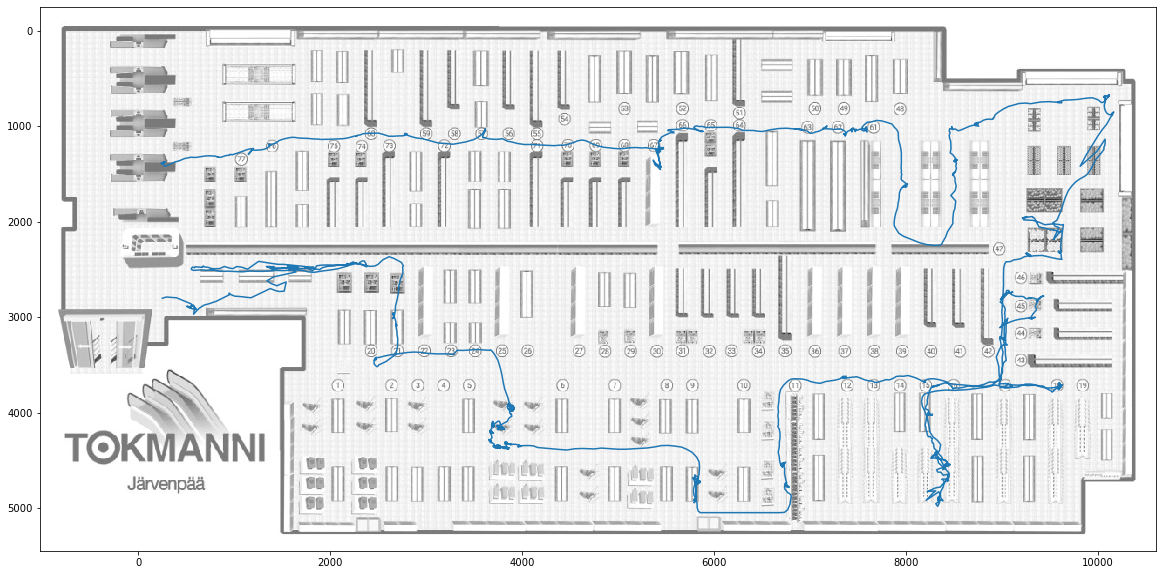

In [112]:
import pylab as plt

img = plt.imread("pic.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=(-1025,10600,5450,-250),aspect='auto')
plt.rcParams['figure.figsize'] = [20,10]

plt.plot(table.X, table.Y, '-')

# Lasketaan kahden vierekkäisen timestampin Delta x ja y, otetaan tähän suoraan aika mukaan jolloin saaadaan m/s
### Saatiin ainakin Y koordinaattien muutokseksi 80 = 1m, tietäen että tokmannin pinta-ala on noin 6200m**2

In [113]:
import math  
metreina = []


# Neliöjuuri ( DX**2 + DY**2 ) saadaan vektorien etäisyys
def matkametreina(x1,y1,x2,y2, t1, t2):
    
    # Aikojen erotus
    dtime = int((t2 - t1) * 10**-9)
    
    # Säästytään 0 jakamiselta
    if dtime == 0: 
        dtime = 1
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2) / dtime
    return dist / 80

# Tässä nyt tapa laittaa arvot ensin listaan *metreina*
# Ehdota parempaa tapaa tehdä tämä.
for i in range(len(table) - 1):   # index outofbounds koska i+1
    x1 = table['X'].values[i]
    y1 = table['Y'].values[i]
    x2 = table['X'].values[i+1]
    y2 = table['Y'].values[i+1]
    t1 = table['T'].values[i]
    t2 = table['T'].values[i+1]
    metreina.append(matkametreina(x1, y1, x2, y2, t1, t2))

# Lisään viimeiseen FALSE arvo koska listojen pituus pitää olla sama.
metreina.append(matkametreina(x1, y1, x2, y2, t1, t2))

# Tehdään dataframeen uusi taulu johon laitetaan listan tavarat
table["m/s"] = metreina

print(table)

       node                   T    X     Y  Z   Q       m/s
45    54016 2019-03-21 07:55:24  252  2802  0  91  0.549574
46    54016 2019-03-21 07:55:25  294  2789  0  70  1.328768
47    54016 2019-03-21 07:55:26  400  2797  0  90  1.022596
48    54016 2019-03-21 07:55:28  551  2860  0  79  0.397748
50    54016 2019-03-21 07:55:30  596  2905  0  75  0.168170
...     ...                 ...  ...   ... ..  ..       ...
3075  54016 2019-03-21 08:43:45  245  1383  0  69  0.051539
3076  54016 2019-03-21 08:43:46  249  1384  0  72  0.000000
3077  54016 2019-03-21 08:43:47  249  1384  0  62  0.055902
3078  54016 2019-03-21 08:43:48  247  1388  0  64  0.080039
3079  54016 2019-03-21 08:43:49  242  1392  0  60  0.080039

[3017 rows x 7 columns]


# Katsotaan onko suuria hyppyjä metrimäärässä sekä keskiarvo


0.26240485907795824

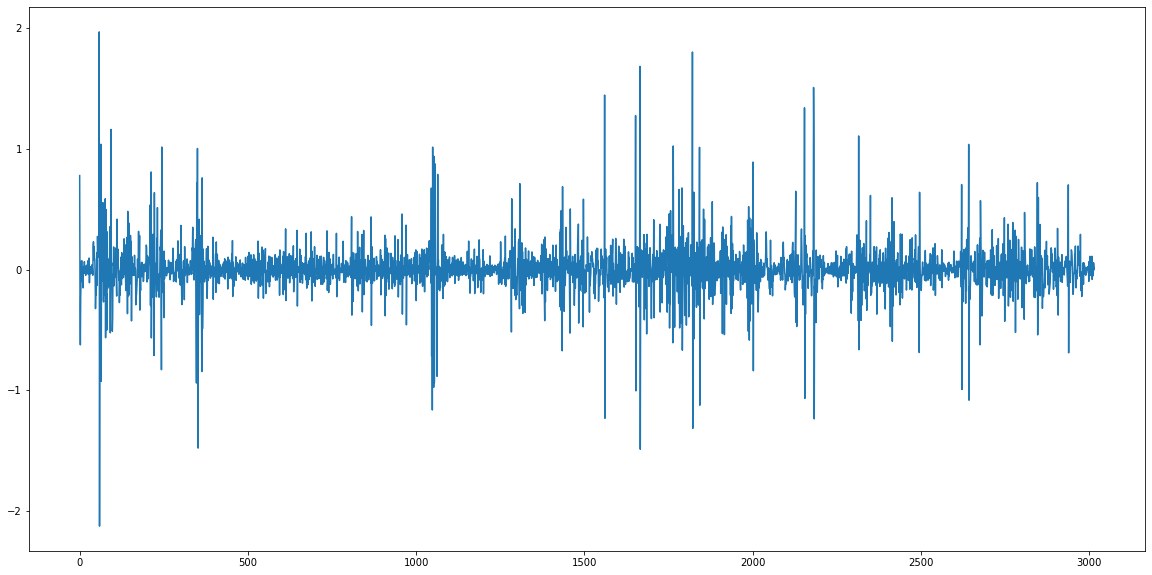

In [118]:
import numpy as np
plt.plot(np.diff(table['m/s']))
table['m/s'].mean(axis = 0)

# Näyttäisi olevan kutakuinkin kunnossa. Otetaan kuitenkin jatkon kannalta kaikki yli 8m/s menevät kärrit pois.
### Laitetaan lisäksi km/h

In [120]:
table = table[table['m/s'] < 8]
table['km/h'] = table['m/s'] * 3.6
print(table['km/h'].mean(axis = 0))
print(table)

0.9446574926806498
       node                   T    X     Y  Z   Q       m/s      km/h
45    54016 2019-03-21 07:55:24  252  2802  0  91  0.549574  1.978465
46    54016 2019-03-21 07:55:25  294  2789  0  70  1.328768  4.783566
47    54016 2019-03-21 07:55:26  400  2797  0  90  1.022596  3.681347
48    54016 2019-03-21 07:55:28  551  2860  0  79  0.397748  1.431891
50    54016 2019-03-21 07:55:30  596  2905  0  75  0.168170  0.605413
...     ...                 ...  ...   ... ..  ..       ...       ...
3075  54016 2019-03-21 08:43:45  245  1383  0  69  0.051539  0.185540
3076  54016 2019-03-21 08:43:46  249  1384  0  72  0.000000  0.000000
3077  54016 2019-03-21 08:43:47  249  1384  0  62  0.055902  0.201246
3078  54016 2019-03-21 08:43:48  247  1388  0  64  0.080039  0.288141
3079  54016 2019-03-21 08:43:49  242  1392  0  60  0.080039  0.288141

[3017 rows x 8 columns]


# TESTAUSTA. Paikat jossa kärry pysähtynyt yms.

In [116]:
pysahdyksissa = pd.DataFrame()
xlista = []
ylista = []

for i in range(len(table)):
    if (table['m/s'].values[i] == 0):
        x = table['X'].values[i]
        y = table['Y'].values[i]
        xlista.append(x)
        ylista.append(y)
        
pysahdyksissa['x'] = xlista
pysahdyksissa['y'] = ylista

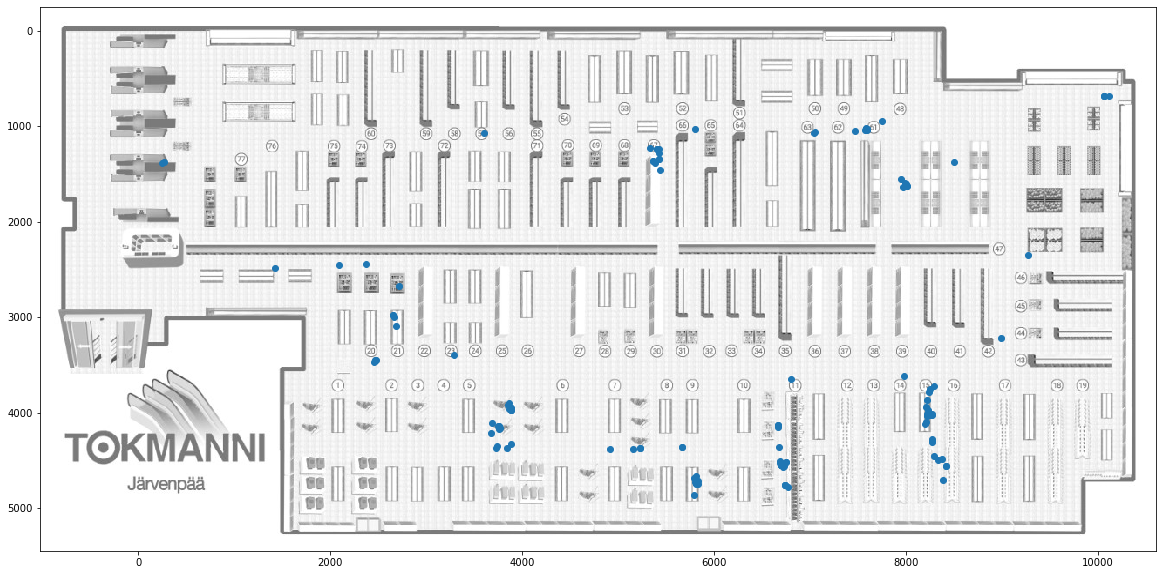

In [117]:
img = plt.imread("pic.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=(-1025,10600,5450,-250),aspect='auto')
plt.rcParams['figure.figsize'] = [20,10]

plt.plot(pysahdyksissa.x, pysahdyksissa.y, 'o')